XAI methods for 3D segmentation

In [56]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import sys 

import torch

import torch.nn.functional as F
from captum.attr import LayerGradCam

import numpy as np 

import matplotlib.pyplot as plt

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
sys.path.append(project_root)

from models import AttentionVNet, VNet
from lit_models import LitBaseVNet
from dataloader import ProstateDataModule, download_and_extract_msd_prostate

In [57]:
# get data

DATA_ROOT = "../data"
download_and_extract_msd_prostate(DATA_ROOT)

dm = ProstateDataModule(
    root_dir=DATA_ROOT, 
    batch_size=2,
    roi_size=(128, 128, 64),
    num_workers=10
)

In [58]:
# import model

checkpoint_path = "../checkpoints/best-attention-vnet-epoch=08-val_dice=0.417.ckpt"
model = LitBaseVNet.load_from_checkpoint(
    checkpoint_path, 
    model_obj=AttentionVNet(in_ch=2, out_ch=3, base_channels=16)
)
model.eval()
# model.cuda()


class xai_wrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        out = self.model(x)
        return out.sum(dim=(2, 3, 4))
    
wrapper_model = xai_wrapper(model)

# select target layer 
# target_layer = model.model.output_conv
target_layer = model.model.decoder.up_layers[-1][0].convt

c:\Users\janis\miniconda3\envs\def\Lib\site-packages\pytorch_lightning\utilities\migration\utils.py:56: The loaded checkpoint was produced with Lightning v2.5.6, which is newer than your current Lightning version: v2.5.5


In [59]:
# Grad cam init
lgc = LayerGradCam(wrapper_model, target_layer)

In [61]:
# Input tensor

dm.setup(stage="fit")
batch = next(iter(dm.val_dataloader()))

x, y = model._prepare_batch(batch)
# x = x.cuda()

input_tensor = x
input_tensor.requires_grad = True

num_classes = 3
attributions = []

for class_id in range(num_classes):
    target_class = class_id # 0 - background, 1 - PZ ,2 - TZ 

    # activation map
    attributions.append(lgc.attribute(input_tensor, target=target_class, relu_attributions=True))

print(f"Activation map size: {attributions[0].shape}")

# prediction
with torch.no_grad():
    logits = model(x)
    preds = torch.argmax(logits, dim=1)
    preds = preds.cpu()


Activation map size: torch.Size([1, 1, 128, 128, 36])


In [63]:
# Interpolation to input size for visualisation
spatial_shape = input_tensor.shape[2:] # get spatial dimension, leave batch and channels
heatmap_3d = []
for class_id in range(num_classes):
    attributions_upsample = LayerGradCam.interpolate(attributions[class_id], spatial_shape, interpolate_mode='trilinear')
    heatmap_3d.append(attributions_upsample.squeeze().cpu().detach().numpy())

    # heatmap_min = heatmap_3d.min()
    # heatmap_max = heatmap_3d.max()
    # heatmap_norm = (heatmap_3d - heatmap_min) / (heatmap_max - heatmap_min + 1e-8)
# find layer with most intense gradient heatmap_norm = (heatmap_3d - heatmap_min) / (heatmap_max - heatmap_min + 1e-8)

In [65]:
# find layer with most intense gradient 
original_image = input_tensor[0, 0, :, :, :].cpu().detach().numpy()

axial_slice_heatmap = []
axial_slice_image = []
i_max_axial = []

coronal_slice_heatmap = []
coronal_slice_image = []
i_max_coronal = []

sagittal_slice_heatmap = []
sagittal_slice_image = []
i_max_sagittal = []

for class_id in range(num_classes):
    # 1. Axial (axis 0)
    axial_sums = np.sum(heatmap_3d[class_id], axis=(1, 2)) 
    i_max_axial.append(np.argmax(axial_sums))
    axial_slice_heatmap.append(heatmap_3d[class_id][i_max_axial[class_id], :, :])
    axial_slice_image.append(original_image[i_max_axial[class_id], :, :])

    # 2. Coronal (axis 1)
    coronal_sums = np.sum(heatmap_3d[class_id], axis=(0, 2)) 
    i_max_coronal.append(np.argmax(coronal_sums))
    coronal_slice_heatmap.append(heatmap_3d[class_id][:, i_max_coronal[class_id], :])
    coronal_slice_image.append(original_image[:, i_max_coronal[class_id] , :])

    # 3. Sagittal (axis 2)
    sagittal_sums = np.sum(heatmap_3d[class_id], axis=(0, 1)) 
    i_max_sagittal.append(np.argmax(sagittal_sums))
    sagittal_slice_heatmap.append(heatmap_3d[class_id][:, :, i_max_sagittal[class_id]])
    sagittal_slice_image.append(original_image[:, : , i_max_sagittal[class_id]])

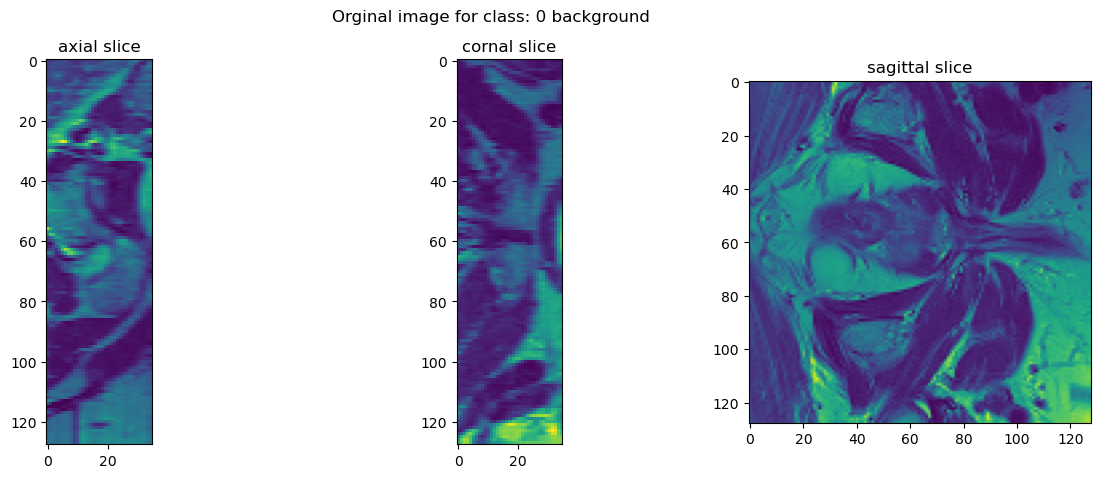

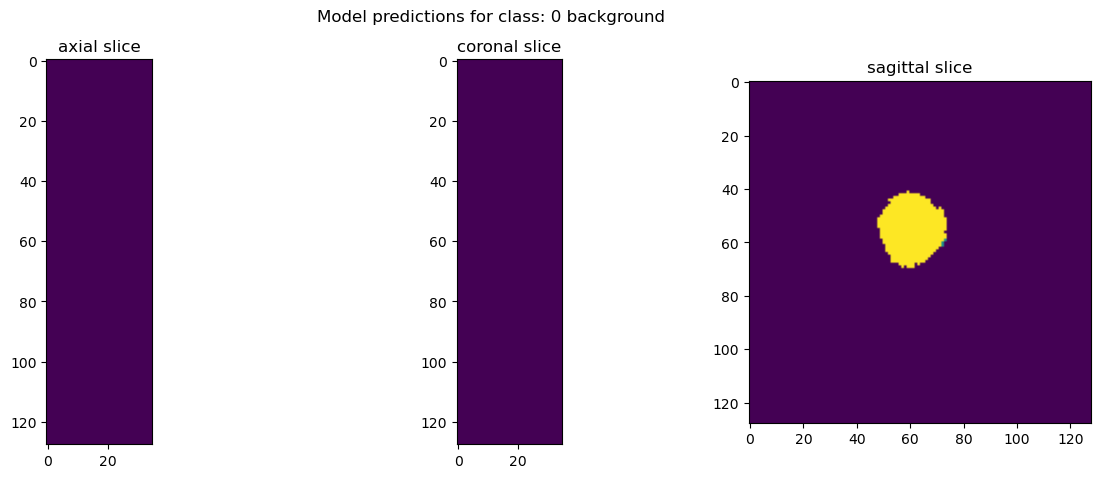

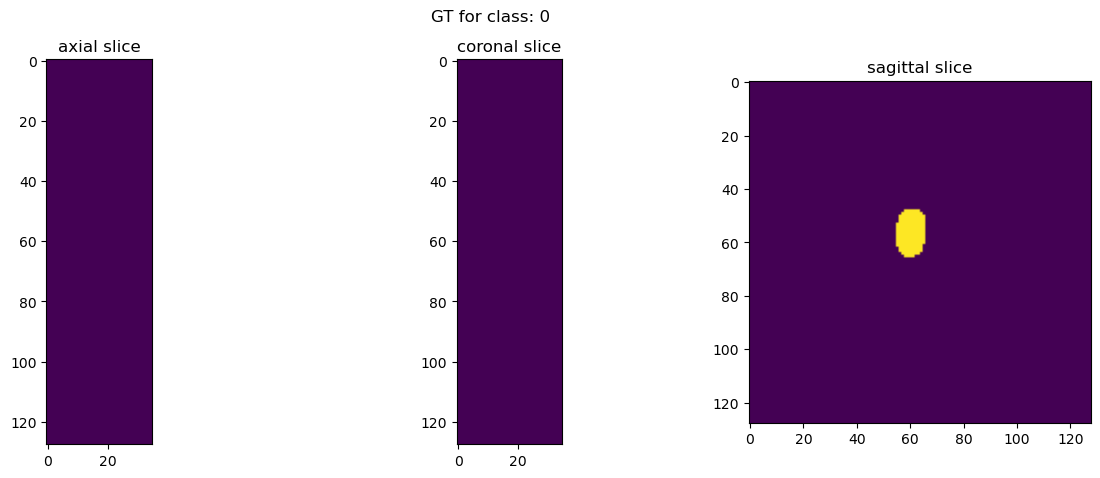

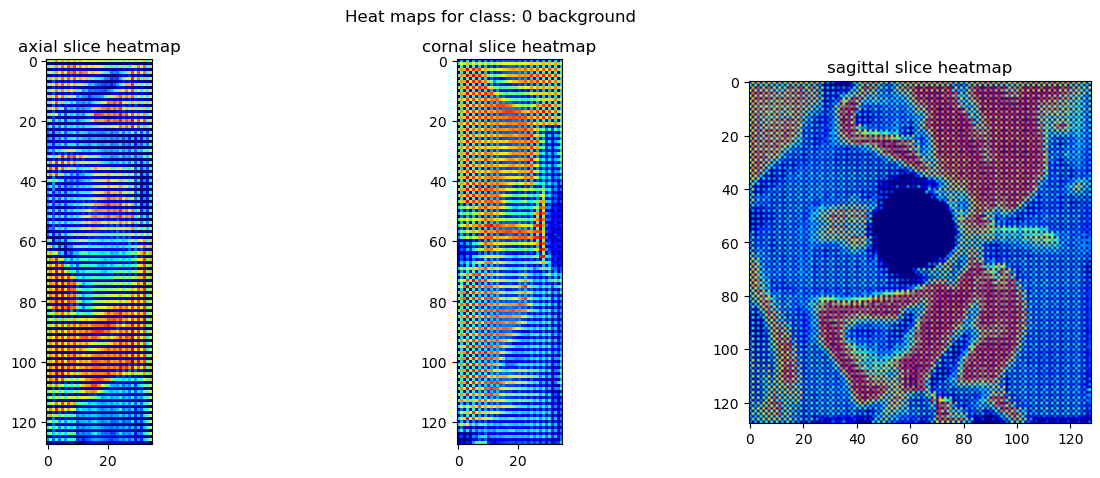

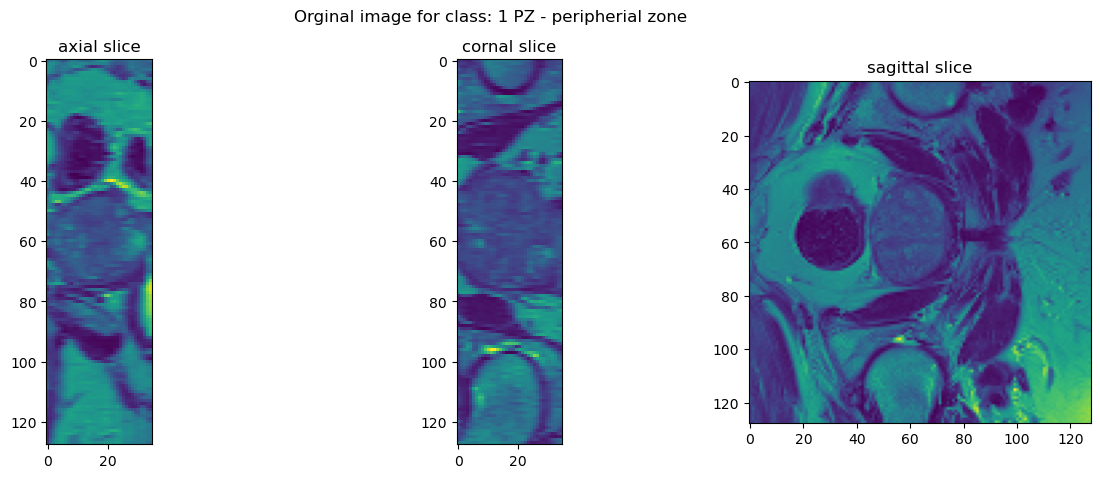

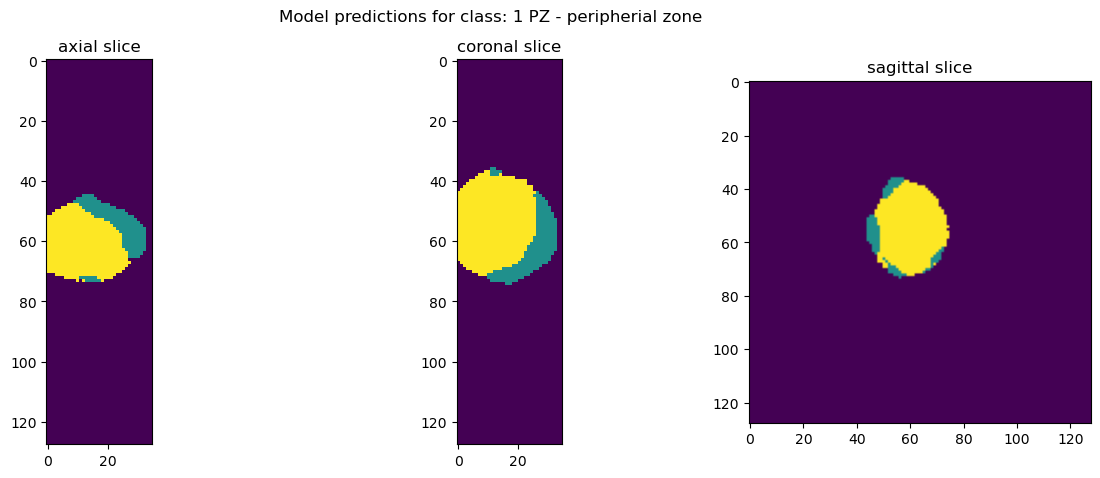

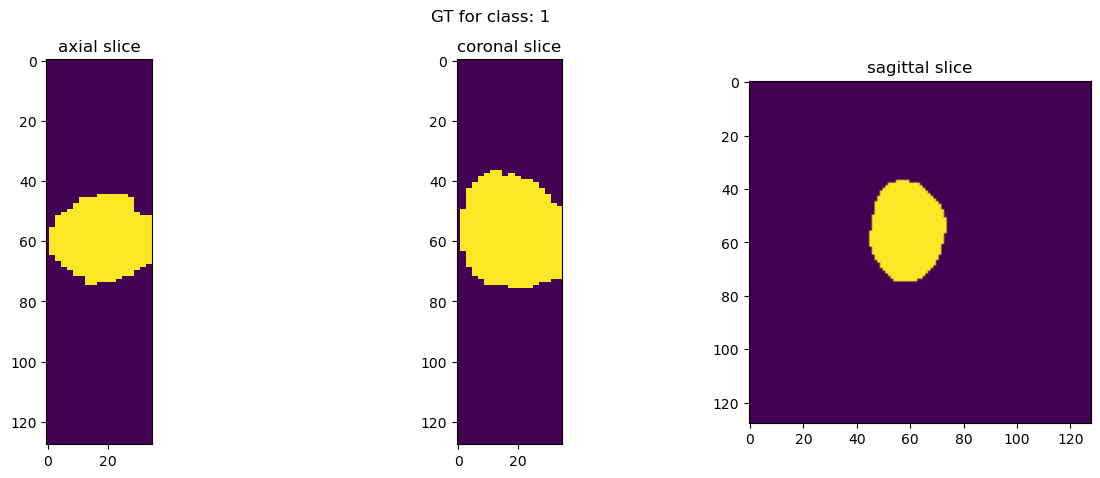

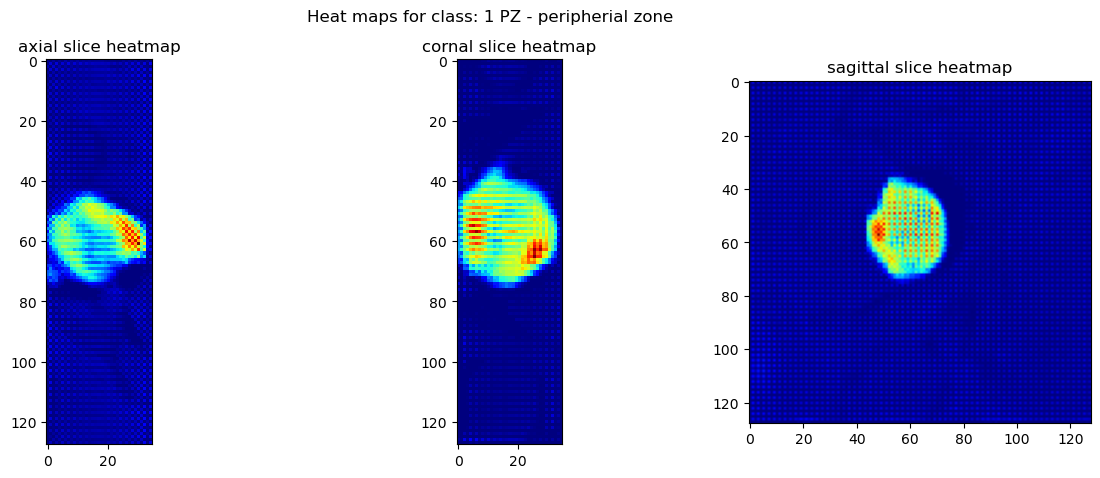

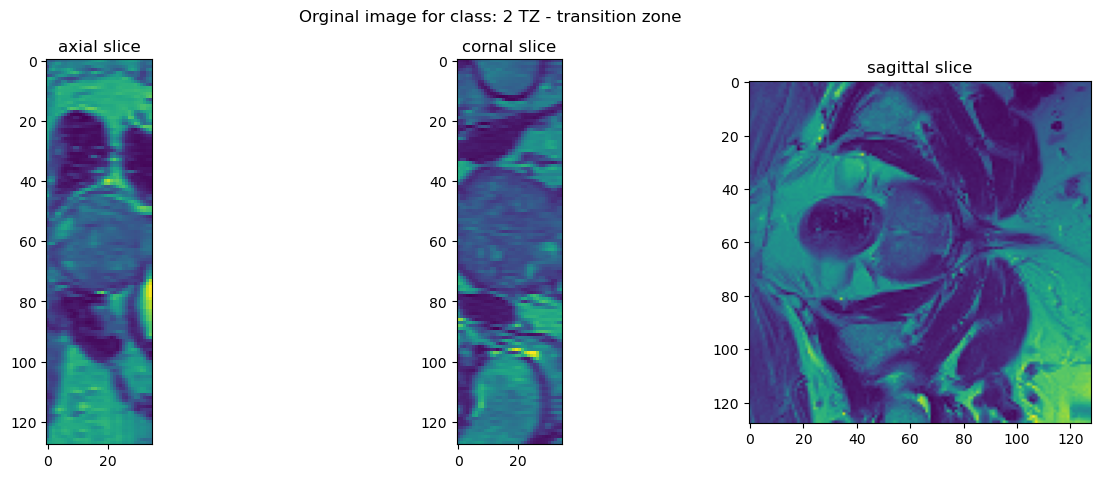

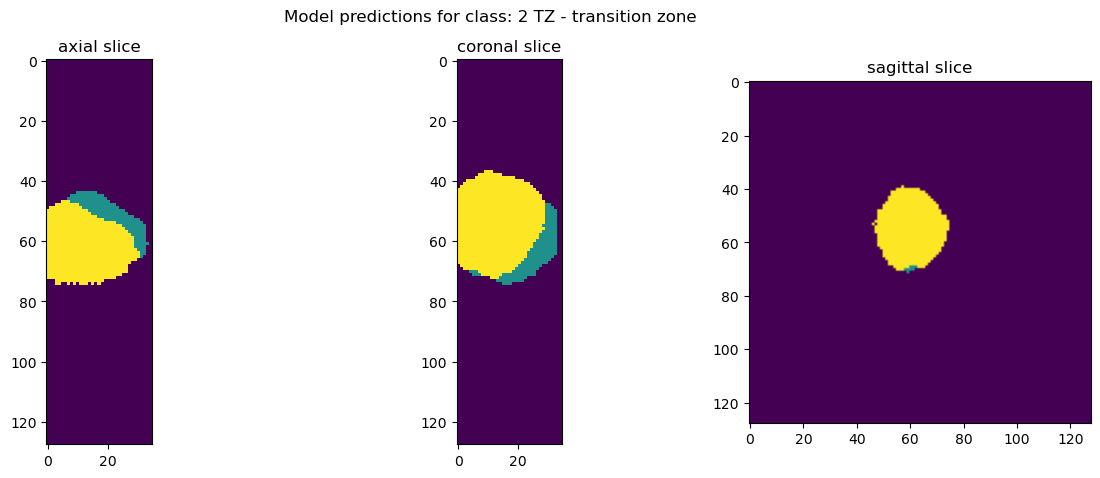

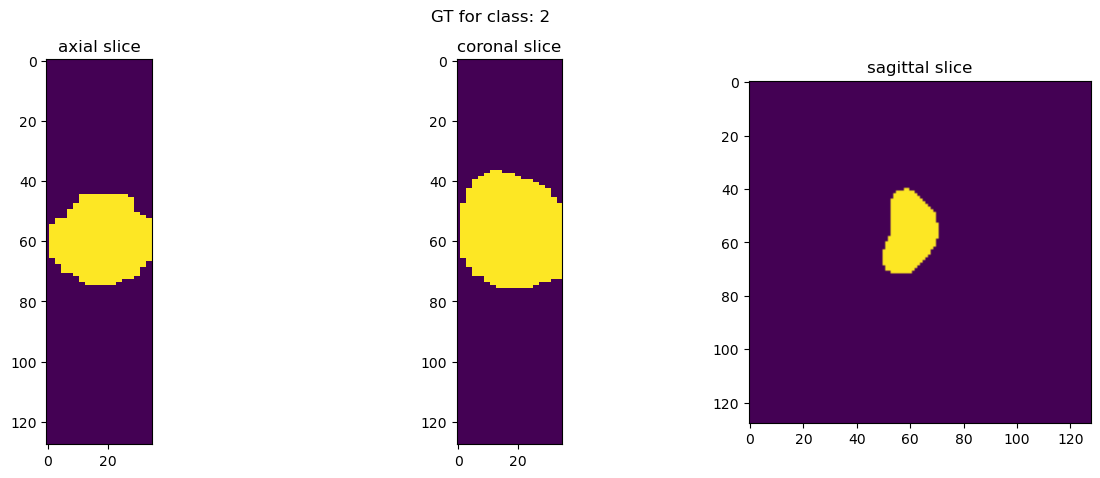

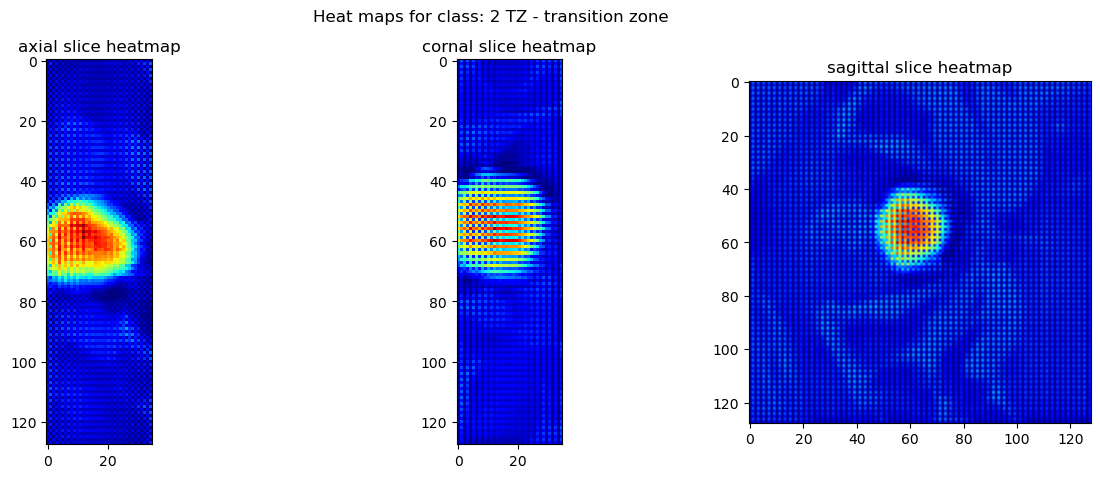

In [ ]:
# visu orginal slices

class_dict = {0:'background', 1:'PZ - peripherial zone', 2:'TZ - transition zone'}

for class_id in range(num_classes):

    # print('='*50, f'\nClass: {class_id}: {class_dict[class_id]}')

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Orginal image for class: {class_id} {class_dict[class_id]}')
    axes[0].imshow(axial_slice_image[class_id])
    axes[0].set_title('axial slice')

    axes[1].imshow(coronal_slice_image[class_id])
    axes[1].set_title('cornal slice')

    axes[2].imshow(sagittal_slice_image[class_id])
    axes[2].set_title('sagittal slice')

    # predictions
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Model predictions for class: {class_id} {class_dict[class_id]}')
    axes[0].imshow(preds[0, i_max_axial[class_id], :, :])
    axes[0].set_title('axial slice')

    axes[1].imshow(preds[0, :, i_max_coronal[class_id], :])
    axes[1].set_title('coronal slice')

    axes[2].imshow(preds[0, :, :, i_max_sagittal[class_id]])
    axes[2].set_title('sagittal slice')


    # gt
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'GT for class: {class_id} {class_dict[class_id]}')
    axes[0].imshow(y[0, 0, i_max_axial[class_id], :, :])
    axes[0].set_title('axial slice')

    axes[1].imshow(y[0, 0, :, i_max_coronal[class_id], :])
    axes[1].set_title('coronal slice')

    axes[2].imshow(y[0, 0, :, :, i_max_sagittal[class_id]])
    axes[2].set_title('sagittal slice')

    # visu attention

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Heat maps for class: {class_id} {class_dict[class_id]}')
    axes[0].imshow(axial_slice_heatmap[class_id], cmap = 'jet')
    axes[0].set_title('axial slice heatmap')

    axes[1].imshow(coronal_slice_heatmap[class_id], cmap = 'jet')
    axes[1].set_title('cornal slice heatmap')

    axes[2].imshow(sagittal_slice_heatmap[class_id], cmap = 'jet')
    axes[2].set_title('sagittal slice heatmap')

plt.show()